In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

# Import v2 modules with abbreviated names
import src.data_management_v2 as dm
from src.structure_manager_v2 import StructureManager
import src.rdf_v2 as rdf
import src.ensembles_v2 as ens
import src.Birch_Murnaghan2 as bm
import src.entropy as ent
import quests

# Set random seed for reproducibility
np.random.seed(42)

folder_path = "data/3k_poscar"
vasp_files = [f for f in os.listdir(folder_path) if f.endswith('.vasp')]
struct_ids = [int(f.replace('.vasp', '')) for f in vasp_files]
struct_ids.sort()


In [2]:
dm.populate_ring_statistics(struct_ids)

Calculating ring statistics: 100%|██████████| 2914/2914 [00:41<00:00, 69.87it/s]



DIAGNOSTIC FOR STRUCTURE 0

=== Structure Info ===
Composition: O16 Si8
Total atoms: 24
Si atoms: 8
O atoms: 16

=== Si-O-Si Bond Angles ===
Number of Si-O-Si angles: 20
Mean angle: 82.1°
Std dev: 43.4°
Min angle: 23.6°
Max angle: 140.5°
Angles < 100°: 11 (55.0%)
  Smallest: 23.6°

=== Si Coordination ===
Mean Si coordination: 4.25
Coordination histogram: [0 0 0 0 6 2]
Edge-sharing tetrahedra pairs: 5

Bond cutoffs being used: {('Si', 'O'): 2.0, ('O', 'Si'): 2.0, ('Si', 'Si'): 3.3, ('O', 'O'): 3.0}

=== Graph Connectivity ===
Number of Si atoms: 8
Number of nodes in graph: 8
Number of edges in graph: 20

Node degree statistics:
  Mean: 5.00
  Min: 4
  Max: 6
  Histogram: [0 0 0 0 1 6 1]

=== Checking for 2-rings (edge-sharing tetrahedra) ===
  Found potential 2-ring: Si 17 - Si 22, shared O: {3, 15}
  Found potential 2-ring: Si 17 - Si 20, shared O: {9, 4}
  Found potential 2-ring: Si 18 - Si 21, shared O: {8, 14}
  Found potential 2-ring: Si 18 - Si 19, shared O: {0, 10}
  Found pote

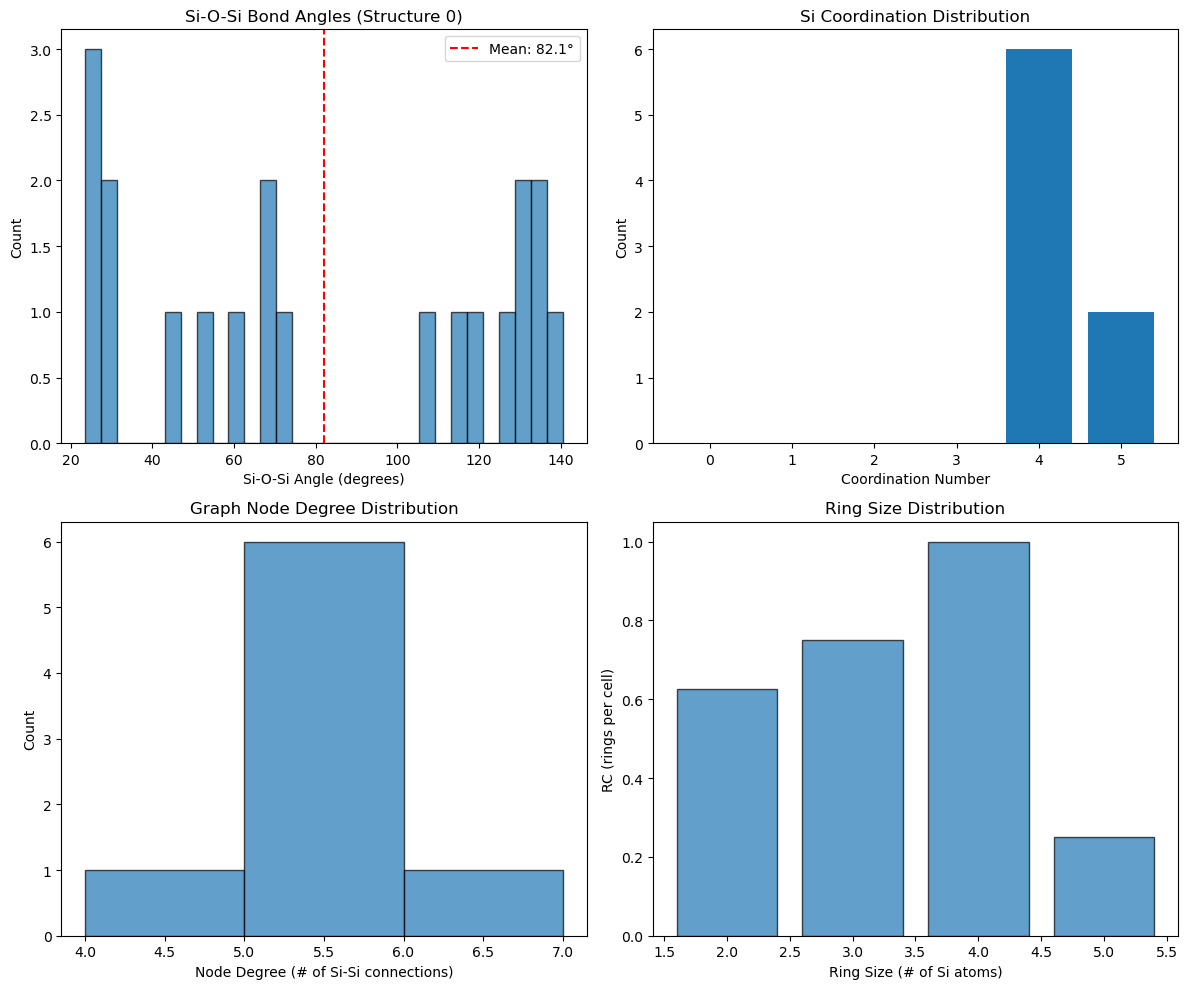

In [7]:
"""
Diagnostic code to investigate ring statistics and Si-O-Si geometry
"""

import numpy as np
import matplotlib.pyplot as plt
from src.data_management_v2 import vasp_to_pymatgen, load_ring_statistics
from src.rings import structure_to_graph, get_bond_cutoffs
import networkx as nx


def calculate_si_o_si_angles(structure, si_o_cutoff=2.0):
    """
    Calculate all Si-O-Si bond angles in the structure.
    
    Returns:
    --------
    list : List of angles in degrees
    """
    angles = []
    
    # Find all Si atoms
    si_indices = [i for i, site in enumerate(structure) 
                  if site.species_string == 'Si']
    
    # For each Si atom, find its O neighbors
    for si_idx in si_indices:
        si_site = structure[si_idx]
        o_neighbors = structure.get_neighbors(si_site, si_o_cutoff)
        
        # For each O neighbor, find other Si atoms bonded to that O
        for o_neighbor in o_neighbors:
            o_idx = o_neighbor.index
            o_site = structure[o_idx]
            
            if o_site.species_string != 'O':
                continue
            
            # Find other Si atoms bonded to this O
            other_si_neighbors = structure.get_neighbors(o_site, si_o_cutoff)
            
            for other_si in other_si_neighbors:
                other_si_idx = other_si.index
                
                # Only count each angle once
                if other_si_idx > si_idx and structure[other_si_idx].species_string == 'Si':
                    # Calculate Si-O-Si angle
                    vec1 = si_site.coords - o_site.coords
                    vec2 = structure[other_si_idx].coords - o_site.coords
                    
                    cos_angle = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
                    cos_angle = np.clip(cos_angle, -1.0, 1.0)  # Handle numerical errors
                    angle = np.arccos(cos_angle) * 180 / np.pi
                    
                    angles.append(angle)
    
    return angles


def analyze_si_coordination(structure, si_o_cutoff=2.0):
    """
    Analyze Si coordination environments.
    
    Returns dict with coordination statistics.
    """
    si_indices = [i for i, site in enumerate(structure) 
                  if site.species_string == 'Si']
    
    coord_numbers = []
    edge_sharing_count = 0
    
    for si_idx in si_indices:
        si_site = structure[si_idx]
        o_neighbors = structure.get_neighbors(si_site, si_o_cutoff)
        o_neighbors = [n for n in o_neighbors if structure[n.index].species_string == 'O']
        
        coord_numbers.append(len(o_neighbors))
        
        # Check for edge-sharing (two Si sharing 2 O atoms)
        o_indices = [n.index for n in o_neighbors]
        
        for other_si_idx in si_indices:
            if other_si_idx <= si_idx:
                continue
            
            other_si_site = structure[other_si_idx]
            other_o_neighbors = structure.get_neighbors(other_si_site, si_o_cutoff)
            other_o_indices = [n.index for n in other_o_neighbors 
                             if structure[n.index].species_string == 'O']
            
            # Count shared O atoms
            shared_o = len(set(o_indices) & set(other_o_indices))
            
            if shared_o >= 2:
                edge_sharing_count += 1
    
    return {
        'coord_numbers': coord_numbers,
        'mean_coord': np.mean(coord_numbers),
        'coord_histogram': np.bincount(coord_numbers),
        'edge_sharing_pairs': edge_sharing_count
    }


def investigate_graph_connectivity(structure, cutoffs):
    """
    Investigate the connectivity graph built for ring analysis.
    """
    graph = structure_to_graph(structure, cutoffs, network_formers=['Si'])
    
    print(f"\n=== Graph Connectivity ===")
    print(f"Number of Si atoms: {sum(1 for site in structure if site.species_string == 'Si')}")
    print(f"Number of nodes in graph: {graph.number_of_nodes()}")
    print(f"Number of edges in graph: {graph.number_of_edges()}")
    
    # Degree distribution
    degrees = [graph.degree(node) for node in graph.nodes()]
    print(f"\nNode degree statistics:")
    print(f"  Mean: {np.mean(degrees):.2f}")
    print(f"  Min: {min(degrees)}")
    print(f"  Max: {max(degrees)}")
    print(f"  Histogram: {np.bincount(degrees)}")
    
    # Check for 2-rings explicitly
    print(f"\n=== Checking for 2-rings (edge-sharing tetrahedra) ===")
    two_rings = []
    for node1 in graph.nodes():
        for node2 in graph.neighbors(node1):
            if node1 < node2:
                # Check if there are 2 parallel edges (multiple O bridges)
                # In our graph, each edge represents one O bridge
                # So we need to check if node1 and node2 share 2 different O atoms
                
                # Get the structure to check
                si1_site = structure[node1]
                si2_site = structure[node2]
                
                # Find O neighbors of each Si
                si_o_cutoff = cutoffs.get(('Si', 'O'), 2.0)
                o_neighbors1 = structure.get_neighbors(si1_site, si_o_cutoff)
                o_neighbors2 = structure.get_neighbors(si2_site, si_o_cutoff)
                
                o_indices1 = set([n.index for n in o_neighbors1 
                                if structure[n.index].species_string == 'O'])
                o_indices2 = set([n.index for n in o_neighbors2 
                                if structure[n.index].species_string == 'O'])
                
                shared_o = o_indices1 & o_indices2
                
                if len(shared_o) >= 2:
                    two_rings.append((node1, node2, shared_o))
                    print(f"  Found potential 2-ring: Si {node1} - Si {node2}, shared O: {shared_o}")
    
    print(f"\nTotal potential 2-rings found: {len(two_rings)}")
    
    return graph, two_rings


def full_diagnostic(struct_id):
    """
    Run full diagnostic on a single structure.
    """
    print(f"\n{'='*70}")
    print(f"DIAGNOSTIC FOR STRUCTURE {struct_id}")
    print(f"{'='*70}")
    
    # Load structure
    structure, energy = vasp_to_pymatgen(struct_id)
    
    # Basic structure info
    print(f"\n=== Structure Info ===")
    composition = structure.composition
    print(f"Composition: {composition}")
    print(f"Total atoms: {len(structure)}")
    print(f"Si atoms: {sum(1 for site in structure if site.species_string == 'Si')}")
    print(f"O atoms: {sum(1 for site in structure if site.species_string == 'O')}")
    
    # Si-O-Si angles
    print(f"\n=== Si-O-Si Bond Angles ===")
    angles = calculate_si_o_si_angles(structure, si_o_cutoff=2.0)
    print(f"Number of Si-O-Si angles: {len(angles)}")
    if len(angles) > 0:
        print(f"Mean angle: {np.mean(angles):.1f}°")
        print(f"Std dev: {np.std(angles):.1f}°")
        print(f"Min angle: {np.min(angles):.1f}°")
        print(f"Max angle: {np.max(angles):.1f}°")
        
        # Check for small angles
        small_angles = [a for a in angles if a < 100]
        print(f"Angles < 100°: {len(small_angles)} ({100*len(small_angles)/len(angles):.1f}%)")
        if small_angles:
            print(f"  Smallest: {min(small_angles):.1f}°")
    
    # Si coordination
    print(f"\n=== Si Coordination ===")
    coord_stats = analyze_si_coordination(structure, si_o_cutoff=2.0)
    print(f"Mean Si coordination: {coord_stats['mean_coord']:.2f}")
    print(f"Coordination histogram: {coord_stats['coord_histogram']}")
    print(f"Edge-sharing tetrahedra pairs: {coord_stats['edge_sharing_pairs']}")
    
    # Graph connectivity
    cutoffs = get_bond_cutoffs(structure, method='default')
    print(f"\nBond cutoffs being used: {cutoffs}")
    
    graph, two_rings = investigate_graph_connectivity(structure, cutoffs)
    
    # Load actual ring statistics if available
    try:
        from src.data_management_v2 import load_ring_statistics
        ring_stats = load_ring_statistics([struct_id])
        
        if struct_id in ring_stats:
            stats = ring_stats[struct_id]
            print(f"\n=== Computed Ring Statistics ===")
            print(f"Ring sizes found: {stats['ring_sizes']}")
            print(f"Total rings: {stats['num_rings_total']}")
            print(f"\nRing size distribution (RC):")
            for size in sorted(stats['RC'].keys()):
                print(f"  {size}-membered: {stats['RC'][size]:.3f}")
    except:
        print("\n(No pre-computed ring statistics found)")
    
    # Make plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Si-O-Si angles
    if len(angles) > 0:
        axes[0, 0].hist(angles, bins=30, alpha=0.7, edgecolor='black')
        axes[0, 0].axvline(np.mean(angles), color='red', linestyle='--', 
                          label=f'Mean: {np.mean(angles):.1f}°')
        axes[0, 0].set_xlabel('Si-O-Si Angle (degrees)')
        axes[0, 0].set_ylabel('Count')
        axes[0, 0].set_title(f'Si-O-Si Bond Angles (Structure {struct_id})')
        axes[0, 0].legend()
    
    # Plot 2: Si coordination
    axes[0, 1].bar(range(len(coord_stats['coord_histogram'])), 
                   coord_stats['coord_histogram'])
    axes[0, 1].set_xlabel('Coordination Number')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Si Coordination Distribution')
    
    # Plot 3: Node degree distribution
    degrees = [graph.degree(node) for node in graph.nodes()]
    axes[1, 0].hist(degrees, bins=range(min(degrees), max(degrees)+2), 
                    alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Node Degree (# of Si-Si connections)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Graph Node Degree Distribution')
    
    # Plot 4: Ring size distribution if available
    try:
        if struct_id in ring_stats:
            stats = ring_stats[struct_id]
            sizes = sorted(stats['RC'].keys())
            rcs = [stats['RC'][s] for s in sizes]
            axes[1, 1].bar(sizes, rcs, alpha=0.7, edgecolor='black')
            axes[1, 1].set_xlabel('Ring Size (# of Si atoms)')
            axes[1, 1].set_ylabel('RC (rings per cell)')
            axes[1, 1].set_title('Ring Size Distribution')
    except:
        axes[1, 1].text(0.5, 0.5, 'No ring statistics computed', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    # plt.savefig(f'/mnt/user-data/outputs/ring_diagnostic_struct_{struct_id}.png', dpi=150)
    # print(f"\nPlot saved to: ring_diagnostic_struct_{struct_id}.png")
    
    return {
        'angles': angles,
        'coord_stats': coord_stats,
        'graph': graph,
        'two_rings': two_rings
    }


# Example usage:

results = full_diagnostic(0)

# # Run on multiple structures
# for struct_id in [0, 1, 2, 10, 100]:
#     results = full_diagnostic(struct_id)


In [4]:
def average_connectivity_matrices(ensemble_stats, threshold=0.05):
    """
    Average connectivity matrices across an ensemble and display nicely.
    
    Parameters:
    -----------
    ensemble_stats : dict
        Dictionary mapping structure_id -> ring_statistics
    threshold : float
        Values below this are shown as '-' for readability
        
    Returns:
    --------
    dict : {
        'average_matrix': np.array,
        'ring_sizes': list,
        'num_structures': int
    }
    """
    # Collect all unique ring sizes across ensemble
    all_ring_sizes = set()
    for stats in ensemble_stats.values():
        all_ring_sizes.update(stats['ring_sizes'])
    
    ring_sizes = sorted(all_ring_sizes)
    n_sizes = len(ring_sizes)
    
    # Create mapping from ring_size to index
    size_to_idx = {size: idx for idx, size in enumerate(ring_sizes)}
    
    # Initialize sum matrix
    sum_matrix = np.zeros((n_sizes, n_sizes))
    
    # Sum all connectivity matrices
    for stats in ensemble_stats.values():
        struct_ring_sizes = stats['ring_sizes']
        struct_matrix = stats['connectivity_matrix']
        
        # Map each structure's matrix to the global matrix
        for i, size_i in enumerate(struct_ring_sizes):
            for j, size_j in enumerate(struct_ring_sizes):
                global_i = size_to_idx[size_i]
                global_j = size_to_idx[size_j]
                sum_matrix[global_i, global_j] += struct_matrix[i, j]
    
    # Average
    n_structures = len(ensemble_stats)
    avg_matrix = sum_matrix / n_structures
    
    # Pretty print
    print(f"\nAverage Connectivity Matrix ({n_structures} structures)")
    print(f"Threshold: {threshold} (values below shown as '-')\n")
    
    # Header
    print("Ring:", end="")
    for size in ring_sizes:
        print(f"  {size:4d}", end="")
    print("\n" + "-" * (6 + 6 * len(ring_sizes)))
    
    # Rows
    for i, size_i in enumerate(ring_sizes):
        print(f"{size_i:4d}:", end="")
        for j, size_j in enumerate(ring_sizes):
            val = avg_matrix[i, j]
            if val < threshold:
                print(f"     -", end="")
            else:
                print(f"  {val:4.2f}", end="")
        print()
    
    return {
        'average_matrix': avg_matrix,
        'ring_sizes': ring_sizes,
        'num_structures': n_structures
    }



In [9]:
rings = dm.load_ring_statistics(struct_ids)
average_connectivity_matrices(rings)


Average Connectivity Matrix (2914 structures)
Threshold: 0.05 (values below shown as '-')

Ring:     2     3     4     5     6     7     8
------------------------------------------------
   2:  0.45  0.31  0.38  0.18     -     -     -
   3:  0.31  0.79  0.71  0.33     -     -     -
   4:  0.38  0.71  0.88  0.34     -     -     -
   5:  0.18  0.33  0.34  0.40     -     -     -
   6:     -     -     -     -  0.06     -     -
   7:     -     -     -     -     -     -     -
   8:     -     -     -     -     -     -     -


{'average_matrix': array([[4.49510981e-01, 3.14430336e-01, 3.77874056e-01, 1.78577557e-01,
         3.13572409e-02, 3.34591627e-03, 5.14756349e-04],
        [3.14430336e-01, 7.93239533e-01, 7.08218943e-01, 3.29143789e-01,
         4.41403569e-02, 5.83390528e-03, 2.14481812e-04],
        [3.77874056e-01, 7.08218943e-01, 8.80104667e-01, 3.42141386e-01,
         3.28586136e-02, 3.98936170e-03, 2.14481812e-04],
        [1.78577557e-01, 3.29143789e-01, 3.42141386e-01, 4.01252574e-01,
         4.00652025e-02, 4.20384351e-03, 4.28963624e-05],
        [3.13572409e-02, 4.41403569e-02, 3.28586136e-02, 4.00652025e-02,
         6.36582018e-02, 5.61942347e-03, 2.14481812e-04],
        [3.34591627e-03, 5.83390528e-03, 3.98936170e-03, 4.20384351e-03,
         5.61942347e-03, 8.19320522e-03, 2.14481812e-04],
        [5.14756349e-04, 2.14481812e-04, 2.14481812e-04, 4.28963624e-05,
         2.14481812e-04, 2.14481812e-04, 6.43445436e-04]]),
 'ring_sizes': [2, 3, 4, 5, 6, 7, 8],
 'num_structures': 2914}